In [1]:
from FireSimulator import *
#from FireSimulatorUtilities import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import sys
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def visualize_forest(axis_handle, data):
    r, c = data.shape
    for i in range(r):
        for j in range(c):
            x = col_to_x(j)
            y = row_to_y(r,i)
            
            rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6)
            
            if data[i,j] == 0:
                rect.set_color('g')
            elif data[i,j] == 1:
     np           rect.set_color('r')
            elif data[i,j] == 2:
                rect.set_color('k')
                
            axis_handle.add_patch(rect)
    
    return axis_handle

In [5]:
grid_size = 25
dp = 0
alpha = 0.2763
beta = np.exp(-0.1)

#p_meas_right = 0.8
#p_meas_wrong = (1 - p_meas_right)*0.5

nn = [(-1,0),(1,0),(0,-1),(0,1)]

8.35s = 0.14m elapsed


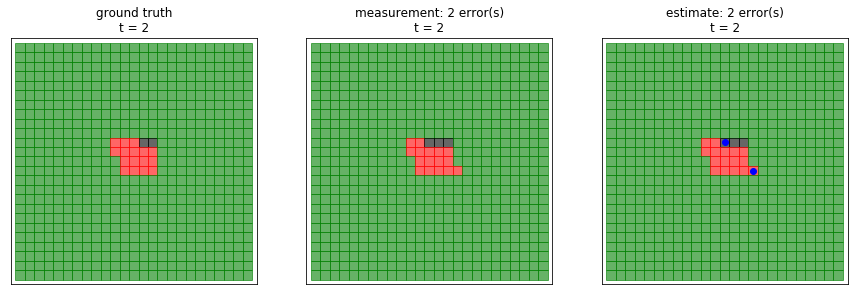

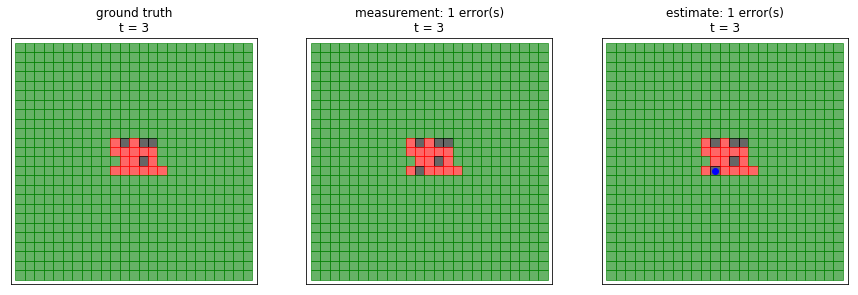

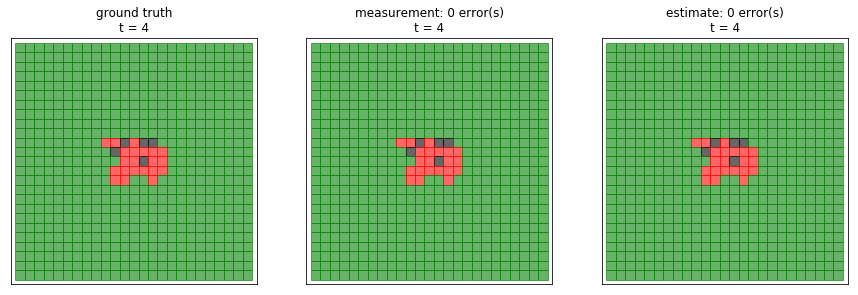

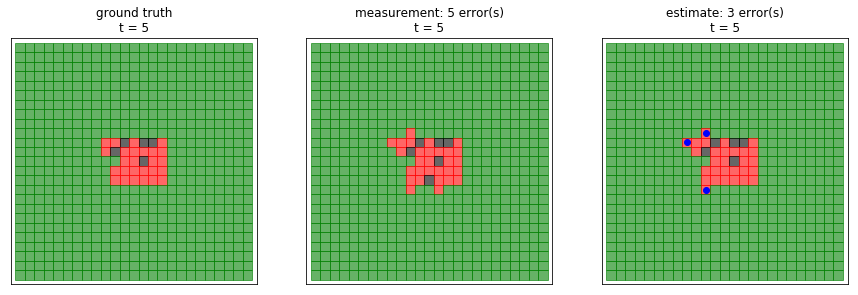

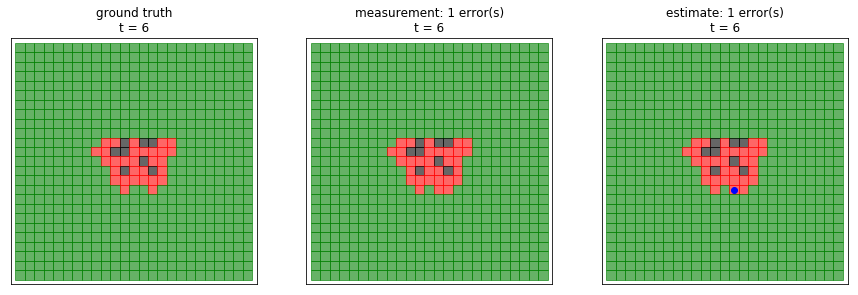

In [4]:
folder = '/bayes/'

np.random.seed(6) # seed 3

sim = FireSimulator(grid_size, alpha=alpha, beta=beta)
plt.close()

sim.step([], dbeta=dp)

belief = np.zeros((grid_size,grid_size,3))
idx = np.where(sim.state==0)
belief[idx[0],idx[1],0] = 1
idx = np.where(sim.state==1)
belief[idx[0],idx[1],1] = 1
idx = np.where(sim.state==2)
belief[idx[0],idx[1],2] = 1

belief = np.zeros((grid_size,grid_size,3))
belief[:,:,0] = 0.34
belief[:,:,1] = 0.33
belief[:,:,2] = 0.33

state_est = np.argmax(belief, axis=2)
meas_matrix = np.copy(sim.state)

plotting = True

if plotting:
    fig = plt.figure(figsize=(15,15))

    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_xlim([0,grid_size+1])
    ax1.set_ylim([0,grid_size+1])
    plt.title('ground truth\nt = %d' %sim.iter)
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax1 = visualize_forest(ax1, sim.state)

    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_xlim([0,grid_size+1])
    ax2.set_ylim([0,grid_size+1])
    plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_matrix != sim.state),sim.iter))
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax2 = visualize_forest(ax2, meas_matrix)

    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_xlim([0,grid_size+1])
    ax3.set_ylim([0,grid_size+1])
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
    ax3 = visualize_forest(ax3, state_est)
    
    rows, cols = np.where(state_est != sim.state)
    for i, j in zip(rows, cols):
        x = col_to_x(j)
        y = row_to_y(grid_size, i)
        plt.plot(x, y, marker='o', color='b')
    
    fn = os.getcwd() + folder + 'img%s' %str(sim.iter).zfill(4)
    plt.savefig(fn, dpi=300, bbox_inches='tight')
    plt.close()  

tic = time.clock()
for _ in range(5):
# while not sim.end:
    #print()
    sim.step([], dbeta=dp)
    
    belief_next = np.zeros_like(belief)
    belief_predict = np.zeros_like(belief)
    meas_matrix = np.zeros_like(sim.state) + -1
    for i in range(grid_size):
        for j in range(grid_size):
            
            # predict belief using dynamics
            b_predict_healthy = 0
            b_predict_fire = 0
            b_predict_burnt = 0
            neighbor_idx = []
            for (di,dj) in nn:
                ii = i + di
                jj = j + dj
                if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                    neighbor_idx.append((ii,jj))
                    
            num_neighbors = len(neighbor_idx)
            for jj in range(3**num_neighbors):
                xj = np.base_repr(jj, base=3).zfill(num_neighbors)
                fi = xj.count('1')
                
                belief_neighbors = 1
                for cnt in range(num_neighbors):
                    belief_neighbors *= belief[neighbor_idx[cnt][0], neighbor_idx[cnt][1], int(xj[cnt])]
                    
                b_predict_healthy += (alpha**fi)*belief_neighbors*belief[i,j,0]
                b_predict_fire += (1 - alpha**fi)*belief_neighbors*belief[i,j,0]
            
            b_predict_fire += beta*belief[i,j,1]
            b_predict_burnt += (1-beta)*belief[i,j,1]
            b_predict_burnt += 1*belief[i,j,2]
            
            belief_predict[i,j,0] = b_predict_healthy
            belief_predict[i,j,1] = b_predict_fire
            belief_predict[i,j,2] = b_predict_burnt
    
    for i in range(grid_size):
        for j in range(grid_size):
            
            # generate measurement
            c = 0.1
            p = 0.03
            fi = 0
            if sim.state[i,j] == 0:
                for (di,dj) in nn:
                    ii = i + di
                    jj = j + dj
                    if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                        if sim.state[ii,jj] == 1:
                            fi += 1
                            
                meas = np.random.choice([0,1,2], p=[1-fi*c,fi*c,0])
                
            elif sim.state[i,j] == 1:
                meas = np.random.choice([0,1,2], p=[0,1-p,p])
                
            elif sim.state[i,j] == 2:
                meas = np.random.choice([0,1,2], p=[0,p,1-p])
                
            #meas = sim.state[i,j]          
            #p_list = [p_meas_wrong,p_meas_wrong,p_meas_wrong]
            #p_list[meas] += p_meas_right - p_meas_wrong
            #meas = np.random.choice([0,1,2], p=p_list)

            meas_matrix[i,j] = meas
            
            # correct prediction with measurement
            fi_p = 0
            neighbor_idx = []
            for (di,dj) in nn:
                ii = i + di
                jj = j + dj
                if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                    neighbor_idx.append((ii,jj))
                    
            num_neighbors = len(neighbor_idx)
            for cnt in range(num_neighbors):
                fi_p += belief_predict[neighbor_idx[cnt][0], neighbor_idx[cnt][1], 1]
            
            if meas == 0:
                belief_next[i,j,0] = (1-fi_p*c)*belief_predict[i,j,0]
                belief_next[i,j,1] = 0*belief_predict[i,j,1]
                belief_next[i,j,2] = 0*belief_predict[i,j,2]
            elif meas == 1:
                belief_next[i,j,0] = fi_p*c*belief_predict[i,j,0]
                belief_next[i,j,1] = (1-p)*belief_predict[i,j,1]
                belief_next[i,j,2] = p*belief_predict[i,j,2]
            elif meas == 2:
                belief_next[i,j,0] = 0*belief_predict[i,j,0]
                belief_next[i,j,1] = p*belief_predict[i,j,1]
                belief_next[i,j,2] = (1-p)*belief_predict[i,j,2]
                
            #if i == 4 and j == 9:
            #    print('measurement: ',meas)
            #    print('number of neighbors on fire: ',fi_p)
            #    print(num_neighbors)
            #    print(neighbor_idx)
            #    for cnt in range(num_neighbors):
            #        print(belief_predict[neighbor_idx[cnt][0], neighbor_idx[cnt][1], :])
            #    #print(belief_predict[i,j-1])
            
    #print(np.sum(belief_next, axis=2)[:,:,np.newaxis])
    normalize = np.sum(belief_next, axis=2)[:,:,np.newaxis]
    belief_next = belief_next / normalize
    state_est = np.argmax(belief_next, axis=2)
        
    if plotting:
        fig = plt.figure(figsize=(15,15))

        ax1 = fig.add_subplot(131, aspect='equal')
        ax1.set_xlim([0,grid_size+1])
        ax1.set_ylim([0,grid_size+1])
        plt.title('ground truth\nt = %d' %sim.iter)
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax1 = visualize_forest(ax1, sim.state)

        ax2 = fig.add_subplot(132, aspect='equal')
        ax2.set_xlim([0,grid_size+1])
        ax2.set_ylim([0,grid_size+1])
        plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_matrix != sim.state),sim.iter))
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax2 = visualize_forest(ax2, meas_matrix)

        ax3 = fig.add_subplot(133, aspect='equal')
        ax3.set_xlim([0,grid_size+1])
        ax3.set_ylim([0,grid_size+1])
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
        ax3 = visualize_forest(ax3, state_est)
        
        rows, cols = np.where(state_est != sim.state)
        for i, j in zip(rows, cols):
            x = col_to_x(j)
            y = row_to_y(grid_size, i)
            plt.plot(x, y, marker='o', color='b')
        
        fn = os.getcwd() + folder + 'img%s' %str(sim.iter).zfill(4)
        plt.savefig(fn, dpi=300, bbox_inches='tight')
        plt.close()  

    if np.any(normalize == 0):
        print(np.sum(belief_next, axis=2))
        #print(np.sum(belief, axis=2))
        break
        
    belief = belief_next

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

### benchmark filter 

first, using point-to-point measurement

measurement is correct 90% of the time

In [22]:
prob_meas_right = 0.9
prob_meas_wrong = 0.05

meas_data = []
est_data = []

tic = time.clock()
# np.random.seed(6) # seed 3
for s in range(100):

    # initialize simulator
    sim = FireSimulator(grid_size, alpha=alpha, beta=beta, rng=s)
    sim.step([], dbeta=dp)

    belief = np.zeros((grid_size,grid_size,3))

    idx = np.where(sim.state==0)
    belief[idx[0],idx[1],0] = 1
    idx = np.where(sim.state==1)
    belief[idx[0],idx[1],1] = 1
    idx = np.where(sim.state==2)
    belief[idx[0],idx[1],2] = 1

    # belief[:,:,0] = 0.34
    # belief[:,:,1] = 0.33
    # belief[:,:,2] = 0.33

    total_est_errors = 0
    total_meas_errors = 0

    for _ in range(10):
    # while not sim.end:
        sim.step([], dbeta=dp)

        belief_next = np.zeros_like(belief)
        belief_predict = np.zeros_like(belief)
        meas_matrix = np.zeros_like(sim.state) + -1

        # predict step for each node
        for i in range(grid_size):
            for j in range(grid_size):

                b_predict_healthy = 0
                b_predict_fire = 0
                b_predict_burnt = 0

                # find indices of neighbors of a node
                neighbor_idx = []
                for (di,dj) in nn:
                    ii = i + di
                    jj = j + dj
                    if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                        neighbor_idx.append((ii,jj))

                # iterate through neighbors        
                num_neighbors = len(neighbor_idx)
                for jj in range(3**num_neighbors):
                    xj = np.base_repr(jj, base=3).zfill(num_neighbors)
                    fi = xj.count('1')

                    belief_neighbors = 1
                    for cnt in range(num_neighbors):
                        belief_neighbors *= belief[neighbor_idx[cnt][0], neighbor_idx[cnt][1], int(xj[cnt])]

                    b_predict_healthy += (alpha**fi)*belief_neighbors*belief[i,j,0]
                    b_predict_fire += (1 - alpha**fi)*belief_neighbors*belief[i,j,0]

                b_predict_fire += beta*belief[i,j,1]
                b_predict_burnt += (1-beta)*belief[i,j,1]
                b_predict_burnt += 1*belief[i,j,2]

                # store predictions
                belief_predict[i,j,0] = b_predict_healthy
                belief_predict[i,j,1] = b_predict_fire
                belief_predict[i,j,2] = b_predict_burnt

        # correct prediction with measurement
        for i in range(grid_size):
            for j in range(grid_size):

                # generate measurement               
                meas = sim.state[i,j]          
                p_list = [prob_meas_wrong,prob_meas_wrong,prob_meas_wrong]
                p_list[meas] += prob_meas_right - prob_meas_wrong
                meas = np.random.choice([0,1,2], p=p_list)

                meas_matrix[i,j] = meas

                # correct prediction with measurement            
                if meas == 0:
                    belief_next[i,j,0] = prob_meas_right*belief_predict[i,j,0]
                    belief_next[i,j,1] = prob_meas_wrong*belief_predict[i,j,1]
                    belief_next[i,j,2] = prob_meas_wrong*belief_predict[i,j,2]
                elif meas == 1:
                    belief_next[i,j,0] = prob_meas_wrong*belief_predict[i,j,0]
                    belief_next[i,j,1] = prob_meas_right*belief_predict[i,j,1]
                    belief_next[i,j,2] = prob_meas_wrong*belief_predict[i,j,2]
                elif meas == 2:
                    belief_next[i,j,0] = prob_meas_wrong*belief_predict[i,j,0]
                    belief_next[i,j,1] = prob_meas_wrong*belief_predict[i,j,1]
                    belief_next[i,j,2] = prob_meas_right*belief_predict[i,j,2]

        normalize = np.sum(belief_next, axis=2)[:,:,np.newaxis]
        belief_next = belief_next / normalize
        state_est = np.argmax(belief_next, axis=2)

        belief = belief_next

        num_est_errors = np.sum(state_est != sim.state)
        total_est_errors += num_est_errors

        num_meas_errors = np.sum(meas_matrix != sim.state)
        total_meas_errors += num_meas_errors
        
    meas_data.append(total_meas_errors / (sim.iter-1))
    est_data.append(total_est_errors / (sim.iter-1))

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

258.89s = 4.31m elapsed


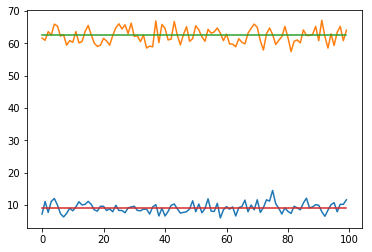

In [34]:
fig = plt.figure()
plt.plot(est_data)
plt.plot(meas_data)
plt.plot(0.1*grid_size**2*np.ones(100))
plt.plot(np.mean(est_data)*np.ones(100))

### old code

In [ ]:
            # healthy
            prob_meas_healthy = 0
            prob_meas_fire = 0
            fi_meas = 0
            
            b_predict_healthy = 0
            b_predict_fire = 0
            neighbor_idx = []
            for (di,dj) in nn:
                ii = i + di
                jj = j + dj
                if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                    neighbor_idx.append((ii,jj))
                    
                    fi_meas += belief[ii,jj,1]
                    fj = 0
                    for (di2,dj2) in nn:
                        iii = ii + di2
                        jjj = jj + dj2
                        if iii>=0 and iii<grid_size and jjj>=0 and jjj<grid_size:
                            fj += belief[iii,jjj,1]
                    
                    fi_meas += (1-alpha**fj)*belief[ii,jj,0]
                    
            prob_meas_healthy = 1-fi_meas*c
            prob_meas_fire = fi_meas*c
            
            num_neighbors = len(neighbor_idx)
            for jj in range(3**num_neighbors):
                xj = np.base_repr(jj, base=3).zfill(num_neighbors)
                fi = xj.count('1')
                
                belief_neighbors = 1
                for cnt in range(num_neighbors):
                    belief_neighbors *= belief[neighbor_idx[cnt][0], neighbor_idx[cnt][1], int(xj[cnt])]
                    
                b_predict_healthy += (alpha**fi)*belief_neighbors*belief[i,j,0]
                b_predict_fire += (1 - alpha**fi)*belief_neighbors*belief[i,j,0]
                
            if meas == 0:
                b_update_healthy = prob_meas_healthy*b_predict_healthy
            elif meas == 1:
                b_update_healthy = prob_meas_fire*b_predict_healthy
            elif meas == 2:
                b_update_healthy = 0*b_predict_healthy
                
            belief_next[i,j,0] = b_update_healthy
                    
            # fire
            b_predict_fire += beta*belief[i,j,1]
            
            if meas == 0:
                b_update_fire = 0*b_predict_fire
            elif meas == 1:
                b_update_fire = (1-p)*b_predict_fire
            elif meas == 2:
                b_update_fire = p*b_predict_fire
                
            belief_next[i,j,1] = b_update_fire
            
            # burnt
            b_predict = 0
            b_predict += (1-beta)*belief[i,j,1]
            b_predict += 1*belief[i,j,2]
            
            if meas == 0:
                b_update = 0*b_predict
            elif meas == 1:
                b_update = p*b_predict
            elif meas == 2:
                b_update = (1-p)*b_predict
                
            belief_next[i,j,2] = b_update